# Classifier

This extension implements a classifier that detects error type and picks the appropriate algorithm for the prevailing type of error

In [1]:
# Importing the Decision Tree Classifier from sklearn
from sklearn.tree import DecisionTreeClassifier

## How is this classifier going to be implemented?

To implement a classifier that detects error type and picks the appropriate algorithm for the prevailing type of error, it would be appropriate to use a decision tree algorithm.

## What are decision trees?

Decision trees are a type of machine learning algorithm that are particularly useful for classification tasks. They are easy to interpret and can handle both categorical and continuous data. The decision tree algorithm works by recursively partitioning the feature space into smaller and smaller subsets, based on the values of the input features, until it reaches a decision about the class label of the data point.

## What are Decision trees used for?

The decision tree classifier is used to classify the type of error that occurs in eye-tracking data, and to pick the appropriate algorithm for correcting the error based on its type.

## Why is the Decision Tree Algorithm appropriate for this Classifier?

Using a decision tree classifier allows for a more efficient and accurate correction of eye-tracking data, since different types of errors require different correction algorithms. By selecting the appropriate algorithm for the type of error, the correction process can be optimized and more effective, leading to higher-quality data for subsequent analysis.

## Which Algorithm should be used for each kind of error?

A summary of the best type of algorithm to use for each kind of error based on the paper:

Noise: The chain algorithm is the most resilient to noise, followed by attach, cluster, regress, and stretch. Compare and split are highly resilient, while segment and warp are entirely invariant.

Slope distortion: Cluster and stretch generally perform best and, initially at least, attach performs worst. Chain and split initially perform better than attach, but are eventually outperformed. Compare and merge are highly resilient to slope, while segment and warp are invariant.

Shift: The compare algorithm is mostly resilient to shift, while attach, chain, regress, split, and stretch are all negatively impacted by increases in shift.

Within-line regression: Compare, segment, and merge are generally quite resilient to within-line regression, while split and warp are highly resilient. Attach, chain, cluster, regress, and stretch are invariant.

Between-line regression: Merge is resilient to between-line regressions, while attach, chain, cluster, regress, and stretch are entirely invariant. Compare and split can in principle find more than m gaze lines, but they have difficulties identifying when a between-line regression occurs, while segment and warp are limited to identifying exactly m gaze lines in strictly sequential order, so they fundamentally cannot handle between-line regressions.

In [2]:
# open the generated synthetic data file and read it as a python dictionary called data

import json

file = open('synthetic_dataset_with_time.txt', 'r')
text = file.read()
data = json.loads(text)

In [3]:
import emip_toolkit as EMTK

# find areas of interest (AOIs) once again
image_path = "./"
image = "synthetic_text.png"
aoi = EMTK.find_aoi(image, image_path, level="sub-line")


# add tokens to AOIs 
file_path = "./"
aois_with_tokens = EMTK.add_tokens_to_AOIs(file_path, image.split(".")[0]+".txt", aoi)
aois_with_tokens.head()


import correction

# find the y coordinate of each line in the text
line_ys = correction.find_lines_Y(aoi)

/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colb

In [4]:
import numpy as np
import drift_algorithms as algo
from tqdm import tqdm

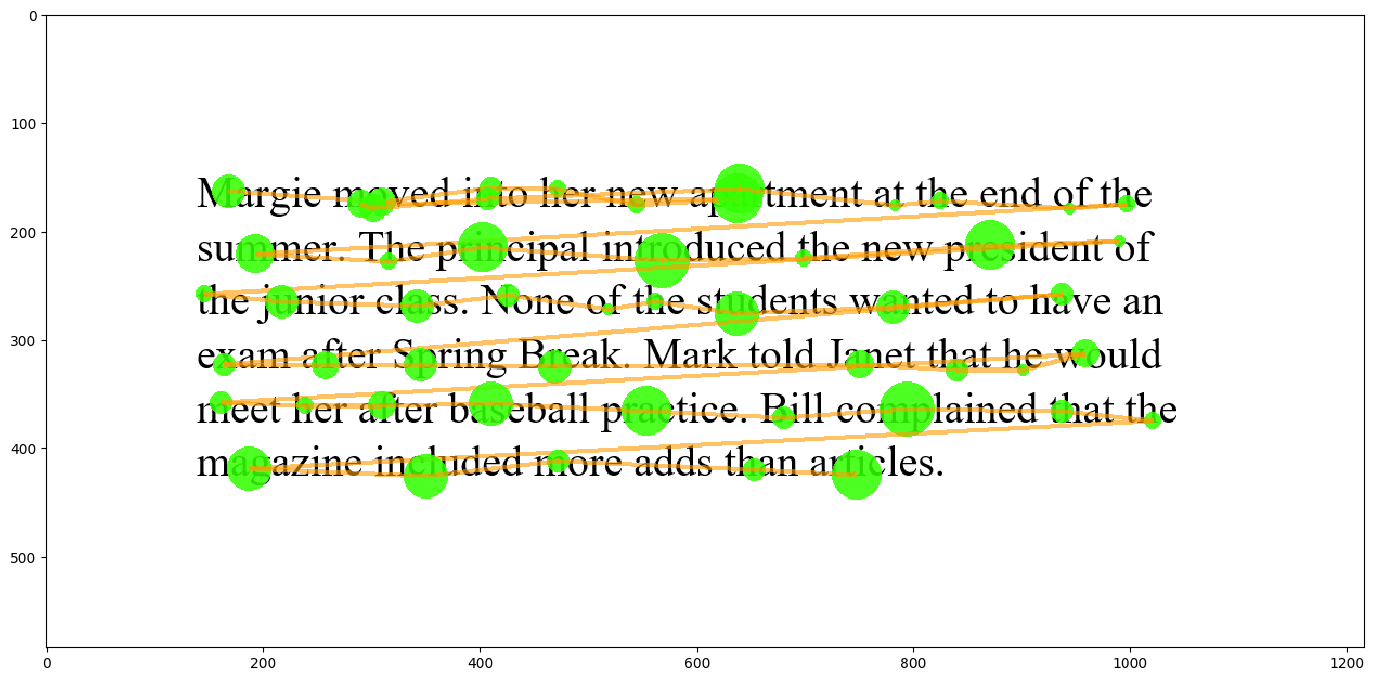

In [5]:
# draw original correct fixations

correction.draw_fixation('synthetic_text.png', data['robot1'].copy())

In [26]:
# Function to extract only the x and y values from the fixations and return them as a list of [x, y]
def extract_xy(fixations):
    fixations_xy = []
    for fixation in fixations:
        fixations_xy.append([fixation[0], fixation[1]])
    return fixations_xy

In [31]:
# Defining the training data set

# Define the training data and labels
# X is the feature matrix (input data) and y is the target vector (output labels)

import random

# Defining the labels for the y values
attach_label = 'attach'
chain_label = 'chain'
cluster_label = 'cluster'
compare_label = 'compare'
merge_label = 'merge'
regress_label = 'regress'
segment_label = 'segment'
split_label = 'split'
stretch_label = 'stretch'
warp_label = 'warp'

word_centers = correction.find_word_centers(aoi)
word_centers = np.array(word_centers.copy(), dtype=int)

duration_word_centers = correction.find_word_centers_and_duration(aois_with_tokens)
duration_word_centers = np.array(duration_word_centers.copy(), dtype=int)

image_path = "./"
image = "synthetic_text.png"
aoi_lines = EMTK.find_aoi(image, image_path, level="line")
aoi_words = EMTK.find_aoi(image, image_path, level="word")

# Creating a sample lsit to store an array of an array of words where each index represents a line
words_sorted_by_line = []

for i in range(len(aoi_lines)):
    words_sorted_by_line.append([])

# Looping through the words and appending them to the correct line
for i in range(len(aoi_words)):
    word_line_number = int(aoi_words.at[i, 'name'].strip().split(' ')[1])
    # Appending the x and y coordinates of the word to the correct line
    words_sorted_by_line[word_line_number-1].append([aoi_words.at[i, 'x'], aoi_words.at[i, 'y']])

# Defining the X feature matrix as an empty array to contain the error generated fixation data
# 2 features error probability and list of fixations
X = []

# Defining the y target vector as an empty array to contain the labels
y = []

for robot_index in tqdm(range(1)):   

    data_copy = data['robot' + str(robot_index)].copy() 

    for error_probability in range(0, 11):

        # Generating noise error fixations
        error_noise = correction.error_noise(error_probability/10, 30, error_probability/10, data['robot' + str(robot_index)].copy())
        # Adding the error probability and only the x and y values of error fixations to the X feature matrix
        X.append(extract_xy(error_noise))

        # Adding the chain label to the y target vector
        y.append(chain_label)

        # Generating the slope error fixations
        slope = -0.125 + (error_probability * 0.025)
        error_slope = correction.error_slope(slope, data['robot' + str(robot_index)].copy())
        # Adding the error probability and the slope value to the X feature matrix
        X.append(extract_xy(error_slope))
        # Adding the cluster label to the y target vector
        y.append(cluster_label)

        # Generating the shift error fixations
        shift = -0.25 + error_probability * 0.05
        error_shift = correction.error_shift(shift, data['robot' + str(robot_index)].copy(), aoi_lines)
        # Adding the error probability and the shift value to the X feature matrix
        X.append(extract_xy(error_shift))
        # Adding the compare label to the y target vector
        y.append(compare_label)

        # Generating the within line error fixations
        error_within_line, data['robot' + str(robot_index)] = correction.error_within_line_regression(error_probability/10, data['robot' + str(robot_index)].copy(), words_sorted_by_line, aoi_lines)
        # Adding the error probability and the within line error fixations to the X feature matrix
        X.append(extract_xy(error_within_line))
        # Adding the segment label to the y target vector
        y.append(segment_label)

        data['robot' + str(robot_index)] = data_copy.copy()

        # Generating the between line error fixations
        error_between_line, data['robot' + str(robot_index)] = correction.error_between_line_regression(error_probability/10, data['robot' + str(robot_index)].copy(), words_sorted_by_line, aoi_lines)
        # Adding the error probability and the between line error fixations to the X feature matrix
        X.append(extract_xy(error_between_line))
        # Adding the merge label to the y target vector
        y.append(merge_label)

# Printing the x feature matrix and the y target vector
# print(X)
# print(y)

temp = list(zip(X, y))
random.shuffle(temp)
X, y = zip(*temp)
# res1 and res2 come out as tuples, and so must be converted to lists.
X, y = list(X), list(y)

# Defining the testing data set

/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colby/Spring 2023/CS421/CS421-project-cmg/emip_toolkit.py:1255: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aoi = aoi.append(dic, ignore_index=True)
/Users/chandrachudgowda/Library/Mobile Documents/com~apple~CloudDocs/Colb

In [34]:
# Creating a decision tree classifier
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

# Convert list to numpy array
X = np.array(X)

# Reshape numpy array
X = np.reshape(X, (X.shape[0], -1))

print(X)
# Training the classifier
clf.fit(X, y)

[[181.16666667 182.         299.5        ... 443.         751.83333333
  441.        ]
 [181.16666667 178.         299.5        ... 397.         751.83333333
  420.        ]
 [181.16666667 178.         299.5        ... 427.         751.83333333
  423.        ]
 ...
 [181.16666667 178.         299.5        ... 427.         751.83333333
  423.        ]
 [181.16666667 178.         299.5        ... 427.         751.83333333
  423.        ]
 [181.16666667 178.         299.5        ... 427.         751.83333333
  423.        ]]


DecisionTreeClassifier()

In [35]:
# Generating different kinds of error fixations and using the classifier to predict the error type see what percentage of each kind of classification are correct
sample_error = correction.error_noise(0.5, 30, 0.5, data['robot1'].copy())
print(sample_error)
# Convert list to numpy array
sample_error = np.array(sample_error)

# Reshape numpy array
sample_error = np.reshape(sample_error, (sample_error.shape[0], -1))
error_type = clf.predict(sample_error)

[[168.16666666666666, 188.0, 370], [309.5, 173.0, 250], [410.1666666666667, 160.0, 200], [471.5, 169.0, 79], [544.5, 176.0, 150], [638.1666666666666, 147.0, 649], [290.5, 155.0, 246], [301.5, 179.0, 250], [407.1666666666667, 195.0, 123], [640.1666666666666, 145.0, 251], [783.5, 182.0, 83], [825.1666666666666, 172.0, 150], [944.5, 179.0, 100], [997.1666666666666, 179.0, 219], [193.16666666666666, 221.0, 350], [315.5, 228.0, 150], [402.5, 185.0, 584], [568.8333333333334, 254.0, 397], [699.1666666666666, 225.0, 150], [870.5, 213.0, 450], [990.5, 214.0, 109], [146.16666666666666, 238.0, 115], [217.5, 247.0, 211], [342.1666666666667, 269.0, 300], [426.1666666666667, 245.0, 239], [518.5, 272.0, 100], [562.1666666666666, 267.0, 148], [637.1666666666666, 270.0, 589], [781.8333333333334, 270.0, 300], [937.1666666666666, 272.0, 265], [164.16666666666666, 323.0, 200], [257.5, 324.0, 250], [345.1666666666667, 323.0, 300], [469.5, 325.0, 300], [750.5, 343.0, 299], [840.1666666666666, 328.0, 200], [

ValueError: X has 3 features, but DecisionTreeClassifier is expecting 96 features as input.